In [1]:
# Load Libraries
library(METAFlux)
library(Seurat)
library(SeuratWrappers)
library(reticulate)
library(dplyr)
library(data.table)
library(purrr)
library(ggplot2)
library(gplots)
library(RColorBrewer)
library(sceasy)
library(reticulate)

#Set Options
options(future.globals.maxSize = 200000 * 1024^2) #for 200GB max size
plan("multicore", workers = 4)

#Load the METAFlux underlying GEM information
data("human_blood")
data("cell_medium")
data("human_gem")
data("nutrient_lookup_files")

# Set Working Directory
setwd("../")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




# Load Data

In [2]:
data <- readRDS("GBMProject/GBMOrganoid/Checkpoints/3_OrganoidPatient_Integrated.rds")
data

An object of class Seurat 
40124 features across 54275 samples within 1 assay 
Active assay: RNA (40124 features, 2000 variable features)
 7 layers present: data, counts, scale.data.TXP_PRO, scale.data.TXP_WT, scale.data.TXP_MES, scale.data.NeftelData, scale.data
 7 dimensional reductions calculated: pca, integrated.cca, umap.integrated.cca, integrated.rpca, umap.integrated.rpca, harmony, umap.harmony

In [3]:
Idents(data) <- 'celltype'
malignant.cells <- subset(data, idents='Malignant')

Idents(malignant.cells) <- 'source'
malignant.cells <- subset(malignant.cells, idents='TXP_WT', invert = TRUE)

malignant.cells

An object of class Seurat 
40124 features across 43683 samples within 1 assay 
Active assay: RNA (40124 features, 2000 variable features)
 6 layers present: data, counts, scale.data.TXP_PRO, scale.data.TXP_MES, scale.data.NeftelData, scale.data
 7 dimensional reductions calculated: pca, integrated.cca, umap.integrated.cca, integrated.rpca, umap.integrated.rpca, harmony, umap.harmony

In [4]:
#check cell types, here we want to model cell-type level flux
table(malignant.cells$source)


PT_Malignant      TXP_MES      TXP_PRO 
       21184        12417        10082 

# Set Neftel State

In [5]:
cell.names <- Cells(malignant.cells)

sample.id <- as.data.frame(malignant.cells$source) %>% mutate(cell.names)

Mes1.score <- as.data.frame(malignant.cells$Neftel_MES11) %>% mutate(cell.names)
Mes2.score <- as.data.frame(malignant.cells$Neftel_MES21) %>% mutate(cell.names)
AC.score <- as.data.frame(malignant.cells$Neftel_AC1) %>% mutate(cell.names)
OPC.score <- as.data.frame(malignant.cells$Neftel_OPC1) %>% mutate(cell.names)
NPC1.score <- as.data.frame(malignant.cells$Neftel_NPC11) %>% mutate(cell.names)
NPC2.score <- as.data.frame(malignant.cells$Neftel_NPC21) %>% mutate(cell.names)

Neftel.scores <- list(sample.id, Mes1.score, Mes2.score, AC.score, OPC.score, NPC1.score, NPC2.score) %>% reduce(full_join, by = "cell.names") %>% select(cell.names, everything())
colnames(Neftel.scores) <- c("cell.names", "Sample.ID", "Mes1.score", "Mes2.score", "AC.score", "OPC.score", "NPC1.score", "NPC2.score")

In [6]:
Neftel.scores <- Neftel.scores %>% rowwise() %>% mutate(NPC.score = mean(c(NPC1.score, NPC2.score)), MES.score = mean(c(Mes1.score, Mes2.score)))
Neftel.scores <- select(Neftel.scores, -c(NPC1.score, NPC2.score, Mes1.score, Mes2.score))
Neftel.scores <- Neftel.scores %>% rowwise() %>% mutate(max.OPC.NPC = max(c(NPC.score, OPC.score)), max.MES.AC = max(c(AC.score, MES.score)))
Neftel.scores <- Neftel.scores %>% rowwise() %>% mutate(metaMod.diff = max.OPC.NPC - max.MES.AC)

# Calculate the difference of the OPC/NPC and AC/MES scores
Neftel.scores <- Neftel.scores %>% rowwise() %>% mutate(OPC.NPC.diff = (OPC.score - NPC.score), AC.MES.diff = (AC.score - MES.score))

# Add columns of y and x coordinates to plot
# For positive metaMod.diff (D), the y coordinate is equal to log2(|D| + 1), and -log2(|D| + 1) for negative values
# (See LeBlanc's https://github.com/vleblanc/GBM-PDE-paper/blob/main/scRNA_seq/fig5_gene_exp_signatures.R for more info)
Neftel.scores <- Neftel.scores %>% rowwise() %>% mutate(y.coord = ifelse(metaMod.diff > 0, log2(abs(metaMod.diff) +1), -log2(abs(metaMod.diff) + 1)))

# Similar calculations to determine x coordinates, with a nested ifelse to determine the main metamodule identity 
Neftel.scores <- Neftel.scores %>% rowwise() %>% mutate(x.coord = ifelse(metaMod.diff > 0, ifelse(OPC.NPC.diff > 0, -log2(abs(OPC.NPC.diff) + 1), log2(abs(OPC.NPC.diff) +1)), ifelse(AC.MES.diff > 0, -log2(abs(AC.MES.diff) +1), log2(abs(AC.MES.diff) + 1))))

# Create a list that contains the barcodes, SampleID, and respective coordinates
cell.coords <- select(Neftel.scores, "cell.names", "Sample.ID", "x.coord", "y.coord")

# Add cell state labels to the individual coordinates, with
# OPC = (-, +), NPC = (+, +), AC = (-, -), MES = (+, -) 
cell.coords <- cell.coords %>% rowwise() %>% 
  mutate(Neftel.label = ifelse(sign(x.coord) > 0, 
                               ifelse(sign(y.coord) > 0, "NPC", "MES"), 
                               ifelse(sign(y.coord) > 0, "OPC", "AC")))
head(Neftel.scores)
head(cell.coords)

cell.names,Sample.ID,AC.score,OPC.score,NPC.score,MES.score,max.OPC.NPC,max.MES.AC,metaMod.diff,OPC.NPC.diff,AC.MES.diff,y.coord,x.coord
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACCCAAGCCTGAGA-1_1,TXP_PRO,-0.0671064,-0.2157413,-0.14114824,0.06276905,-0.1411482,0.06276905,-0.2039173,-0.07459304,-0.1298754,-0.2677363,0.1761637
AAACCCAAGGTCCTGC-1_1,TXP_PRO,-0.4155444,-0.1744819,0.56399490,-0.25084879,0.5639949,-0.25084879,0.8148437,-0.73847684,-0.1646956,0.8598453,0.7978238
AAACCCAGTGAGTCAG-1_1,TXP_PRO,-0.2052438,-0.2096863,-0.17746865,-0.04805518,-0.1774686,-0.04805518,-0.1294135,-0.03221761,-0.1571887,-0.1755737,0.2106241
AAACCCAGTTCCAAAC-1_1,TXP_PRO,0.6069735,0.2204899,0.07388801,-0.06169368,0.2204899,0.60697346,-0.3864835,0.14660193,0.6686671,-0.4714305,-0.7386962
AAACCCAGTTTGCCGG-1_1,TXP_PRO,-0.3153627,-0.2681697,-0.18428587,-0.06388520,-0.1842859,-0.06388520,-0.1204007,-0.08388378,-0.2514775,-0.1640147,0.3236323
AAACCCATCTTGAACG-1_1,TXP_PRO,-0.3195513,-0.2297561,-0.14585688,0.03255188,-0.1458569,0.03255188,-0.1784088,-0.08389919,-0.3521032,-0.2368401,0.4352052


cell.names,Sample.ID,x.coord,y.coord,Neftel.label
<chr>,<chr>,<dbl>,<dbl>,<chr>
AAACCCAAGCCTGAGA-1_1,TXP_PRO,0.1761637,-0.2677363,MES
AAACCCAAGGTCCTGC-1_1,TXP_PRO,0.7978238,0.8598453,NPC
AAACCCAGTGAGTCAG-1_1,TXP_PRO,0.2106241,-0.1755737,MES
AAACCCAGTTCCAAAC-1_1,TXP_PRO,-0.7386962,-0.4714305,AC
AAACCCAGTTTGCCGG-1_1,TXP_PRO,0.3236323,-0.1640147,MES
AAACCCATCTTGAACG-1_1,TXP_PRO,0.4352052,-0.2368401,MES


In [7]:
malignant.cells <- AddMetaData(malignant.cells, cell.coords, col.name = "Neftel.label")

Warning message:
“Setting row names on a tibble is deprecated.”


# Pipeline for multiple samples/patients

In [8]:
# Update functions for Seurat v5
generate_boots <- function(celltype, n) {
  dt <- data.frame(cluster = celltype, id = 1:length(celltype))
  index <- do.call(cbind, sapply(1:n, function(x) {
    splits <- dt %>%
      group_by(cluster) %>%
      sample_n(dplyr::n(), replace = TRUE) %>%
      ungroup() %>%
      dplyr::select("id")
  }))
  return(index)
}

get_ave_exp <- function(i, myseurat, samples,myident) {
  meta.data=myseurat@meta.data[samples[,i],]
  sample <-GetAssayData(myseurat, assay = "RNA")[,samples[,i]]
  name <- colnames(sample)
  for (j in 1:length(name)) {
    name[j] <- paste0(name[j], "_", j)
  }
  colnames(sample) <- name
  rownames(meta.data) <- name
  SeuratObject<-suppressWarnings(
    CreateSeuratObject(count=sample, meta.data = meta.data))
  SeuratObject<-NormalizeData(SeuratObject,verbose = TRUE)
  ave<-GetAssayData(AverageExpression(SeuratObject,group.by = myident,return.seurat = T), assay = "RNA") %>% as.data.frame()
  return(ave)
}

edit_calculate_avg_exp <- function(myseurat,myident,n_bootstrap,seed) {
  set.seed(seed)
  samples=generate_boots(myseurat@meta.data[,myident],n_bootstrap)
  exp <- lapply(1:n_bootstrap,get_ave_exp,myseurat,samples,myident)
  exp <- do.call(cbind, exp)
  return(exp)
}

In [9]:
obj.list <- SplitObject(malignant.cells, split.by = "source")

for (i in c(1:length(obj.list))){
    sc<-obj.list[[i]]
    mean_exp=edit_calculate_avg_exp(myseurat = sc, myident = 'Neftel.label', n_bootstrap = 50, seed = 1) 
    scores<-calculate_reaction_score(data=mean_exp)
    #g=round(table(sc$Cell_type)/nrow(sc@meta.data),3)
    g=table(sc$Neftel.label)/nrow(sc@meta.data)
    print(g)
    flux=compute_sc_flux(num_cell = 4,fraction =c(g[1],g[2],g[3],g[4]),fluxscore=scores,medium = human_blood)
    saveRDS(flux,paste0("GBMProject/GBMOrganoid/METAFlux/METAFluxObject_",i,".rds"))
}

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
Centering and scaling data matrix

Warning message in size + sum(size_args, na.rm = FALSE):
“NAs produced by integer overflow”
Centering and scaling data matrix

Warning message in size + sum(size_args, na.rm = FALSE):
“NAs produced by integer overflow”
Centering and scaling data matrix

Warning message in size + sum(size_args, na.rm = FALSE):
“NAs produced by integer overflow”
Centering and scaling data matrix

Warning message in size + sum(size_args, na.rm = FALSE):
“NAs produced by integer overflow”
Centering and scaling data matrix

Warning message in size + sum(size_args, na.rm = FALSE):
“NAs produced by integer overflow”
Centering and scaling data matrix

Warning message in size + sum(size_args, na.rm = FALSE):
“NAs produced by integer overflow”
Centering and scaling data matrix

Warning message in size + sum(size_args, na.rm = FALSE):
“NAs produced


        AC        MES        NPC        OPC 
0.09799643 0.56318191 0.32652252 0.01229915 


Preparing for TME S matrix.....

S matrix completed......

Compute metabolic flux......



  |======================================================================| 100%


Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scalin


        AC        MES        NPC        OPC 
0.72038335 0.12112427 0.01626802 0.14222437 


Preparing for TME S matrix.....

S matrix completed......

Compute metabolic flux......



  |======================================================================| 100%


Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scalin


       AC       MES       NPC       OPC 
0.3571091 0.2228097 0.2782289 0.1418523 


Preparing for TME S matrix.....

S matrix completed......

Compute metabolic flux......



  |======================================================================| 100%


# Create an average expression profile

In [10]:
# Update functions for Seurat v5
generate_boots <- function(celltype, n) {
  dt <- data.frame(cluster = celltype, id = 1:length(celltype))
  index <- do.call(cbind, sapply(1:n, function(x) {
    splits <- dt %>%
      group_by(cluster) %>%
      sample_n(dplyr::n(), replace = TRUE) %>%
      ungroup() %>%
      dplyr::select("id")
  }))
  return(index)
}

get_ave_exp <- function(i, myseurat, samples,myident) {
  meta.data=myseurat@meta.data[samples[,i],]
  sample <-GetAssayData(myseurat, assay = "RNA")[,samples[,i]]
  name <- colnames(sample)
  for (j in 1:length(name)) {
    name[j] <- paste0(name[j], "_", j)
  }
  colnames(sample) <- name
  rownames(meta.data) <- name
  SeuratObject<-suppressWarnings(
    CreateSeuratObject(count=sample, meta.data = meta.data))
  SeuratObject<-NormalizeData(SeuratObject,verbose = TRUE)
  ave<-GetAssayData(AverageExpression(SeuratObject,group.by = myident,return.seurat = T), assay = "RNA") %>% as.data.frame()
  return(ave)
}

edit_calculate_avg_exp <- function(myseurat,myident,n_bootstrap,seed) {
  set.seed(seed)
  samples=generate_boots(myseurat@meta.data[,myident],n_bootstrap)
  exp <- lapply(1:n_bootstrap,get_ave_exp,myseurat,samples,myident)
  exp <- do.call(cbind, exp)
  return(exp)
}

In [11]:
mean_exp = edit_calculate_avg_exp(myseurat = malignant.cells, myident = 'source', n_bootstrap = 50, seed = 1) 

Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.
Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix



# Calculate MRAS(Metabolic Reaction Activity Score)

In [12]:
#calculate metabolic reaction scores
scores<-calculate_reaction_score(data=mean_exp)

98.152% metabolic related genes were found......

Computing metabolic reaction activity scores......

Preparing for score matrix......

Metabolic reaction activity scores successfully calculated 




In [13]:
head(scores,4)

,PT-Malignant,TXP-MES,TXP-PRO,PT-Malignant.1,TXP-MES.1,TXP-PRO.1,PT-Malignant.2,TXP-MES.2,TXP-PRO.2,PT-Malignant.3,⋯,TXP-PRO.46,PT-Malignant.47,TXP-MES.47,TXP-PRO.47,PT-Malignant.48,TXP-MES.48,TXP-PRO.48,PT-Malignant.49,TXP-MES.49,TXP-PRO.49
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HMR_3905,0.0014217462,0.0015665690,0.0009174082,0.0014118337,0.0015371623,0.0009296509,0.0014232315,0.0015451202,0.0009323761,0.0013957557,⋯,0.0009322500,0.0014100970,0.0015296328,0.0009420041,0.0014016293,0.0015722586,0.0009562730,0.0014230908,0.0015288125,0.0009334271
HMR_3907,0.0008444467,0.0007283353,0.0008372917,0.0008625560,0.0007273964,0.0008337053,0.0008491067,0.0007347738,0.0008462021,0.0008569163,⋯,0.0008215570,0.0008509214,0.0007287831,0.0008348075,0.0008463745,0.0007053034,0.0008432788,0.0008598996,0.0007031739,0.0008169269
HMR_4097,0.0003009337,0.0001923871,0.0001874410,0.0003148534,0.0002254936,0.0001879065,0.0003050400,0.0002067269,0.0001795898,0.0003081399,⋯,0.0001954827,0.0002972399,0.0001754101,0.0001836350,0.0003030631,0.0002057254,0.0001795254,0.0003076257,0.0002090528,0.0001867283
HMR_4099,0.0012321423,0.0012033731,0.0008001643,0.0012125598,0.0011703946,0.0007772107,0.0012344858,0.0012023326,0.0007842431,0.0012228306,⋯,0.0007780798,0.0012445290,0.0011820588,0.0007654855,0.0012342122,0.0011802065,0.0007672388,0.0012218423,0.0011556976,0.0007777856


# Compute flux

In [14]:
#calculate the fractions of celltype/clusters
round(table(malignant.cells$source)/nrow(malignant.cells@meta.data),1)


PT_Malignant      TXP_MES      TXP_PRO 
         0.5          0.3          0.2 

In [15]:
#calculate flux,here we used human blood as our medium, but please change to cell line medium if you sample is from cell line.
#num_cell:number of cell types/clusters=4
flux=compute_sc_flux(num_cell = 3,fraction =c(0.5,0.3,0.2),fluxscore=scores,medium = human_blood)

Preparing for TME S matrix.....

S matrix completed......

Compute metabolic flux......



  |======================================================================| 100%


In [16]:
#Apply cubic root normalization to flux scores.
cbrt <- function(x) {
    sign(x) * abs(x)^(1/3)
}

flux=cbrt(flux)

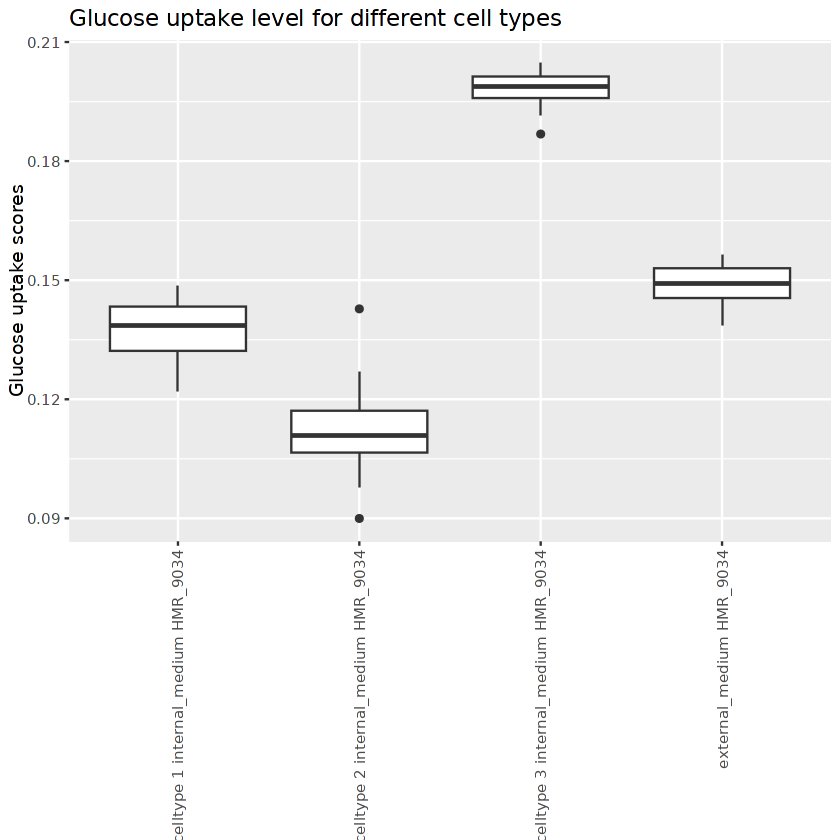

In [17]:
glucose<-data.frame(glucose=flux[grep("HMR_9034",rownames(flux)),])

glucose$celltype=rownames(glucose)
long_glucose=reshape2::melt(glucose,id.vars='celltype')

ggplot(long_glucose,aes(y=-value,x=celltype))+geom_boxplot()+ggtitle("Glucose uptake level for different cell types")+xlab("")+ylab("Glucose uptake scores")+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

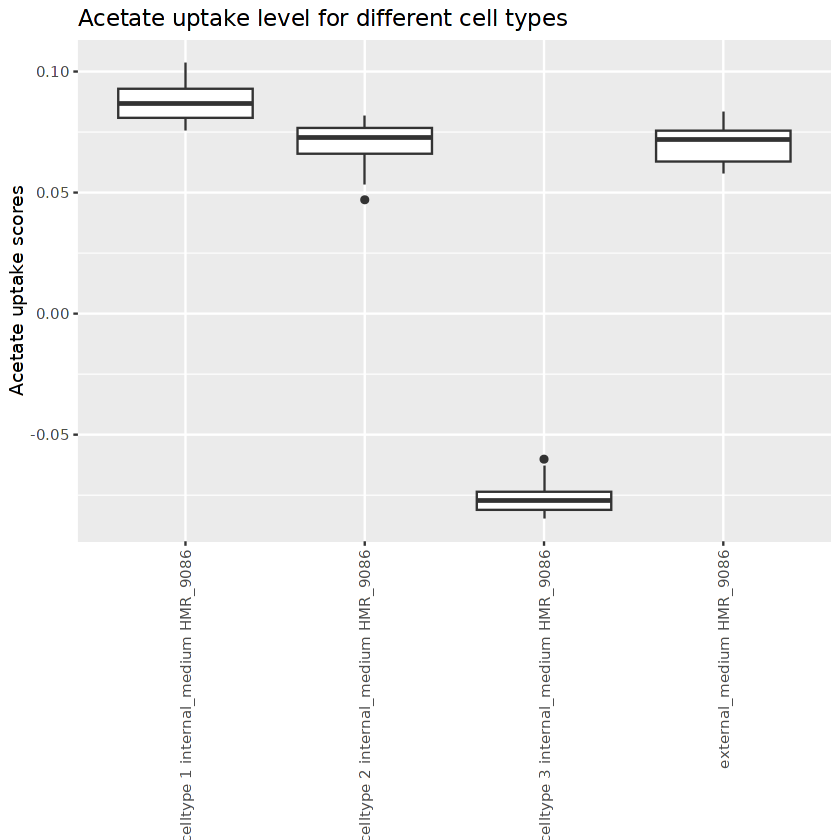

In [18]:
acetate<-data.frame(acetate=flux[grep("HMR_9086",rownames(flux)),])

acetate$celltype=rownames(acetate)
long_acetate=reshape2::melt(acetate,id.vars='celltype')
ggplot(long_acetate,aes(y=-value,x=celltype))+geom_boxplot()+ggtitle("Acetate uptake level for different cell types")+xlab("")+ylab("Acetate uptake scores")+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [39]:
long_pyruvates

celltype,variable,value
<chr>,<fct>,<dbl>
celltype 1 internal_medium HMR_9133,pyruvates.V1,0.1406629
celltype 2 internal_medium HMR_9133,pyruvates.V1,0.1082860
celltype 3 internal_medium HMR_9133,pyruvates.V1,0.1386865
external_medium HMR_9133,pyruvates.V1,0.1321154
celltype 1 internal_medium HMR_9133,pyruvates.V2,0.1405913
celltype 2 internal_medium HMR_9133,pyruvates.V2,0.1100954
celltype 3 internal_medium HMR_9133,pyruvates.V2,0.1390699
external_medium HMR_9133,pyruvates.V2,0.1325290
celltype 1 internal_medium HMR_9133,pyruvates.V3,0.1405431


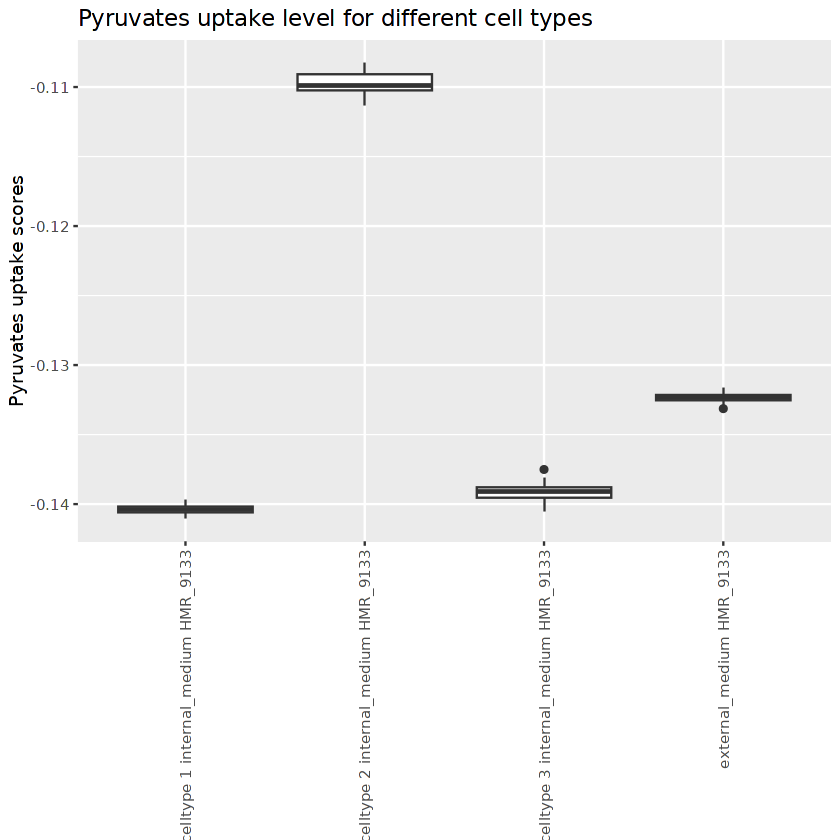

In [19]:
pyruvates<-data.frame(pyruvates=flux[grep("HMR_9133",rownames(flux)),])

pyruvates$celltype=rownames(pyruvates)
long_pyruvates=reshape2::melt(pyruvates,id.vars='celltype')
ggplot(long_pyruvates,aes(y=-value,x=celltype))+geom_boxplot()+ggtitle("Pyruvates uptake level for different cell types")+xlab("")+ylab("Pyruvates uptake scores")+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Save Checkpoint

In [20]:
write.csv(nutrient_lookup_files, "GBMProject/GBMOrganoid/nutrient.csv")

In [30]:
write.csv(human_gem, "GBMProject/GBMOrganoid/human_gem.csv")

In [21]:
saveRDS(flux,paste0("GBMProject/GBMOrganoid/METAFlux/METAFluxObject_Combined.rds"))

In [10]:
#install.packages("palmerpenguins")
library(palmerpenguins)

In [12]:
dat <- penguins %>%
  select(species, flipper_length_mm)
dat

species,flipper_length_mm
<fct>,<int>
Adelie,181
Adelie,186
Adelie,195
Adelie,NA
Adelie,193
Adelie,190
Adelie,181
Adelie,195
Adelie,193


# Visualization

In [2]:
# reload data
pro.flux <- readRDS("GBMProject/GBMOrganoid/METAFlux/METAFluxObject_PRO.rds")
mes.flux <- readRDS("GBMProject/GBMOrganoid/METAFlux/METAFluxObject_MES.rds")
pt.flux <- readRDS("GBMProject/GBMOrganoid/METAFlux/METAFluxObject_PT.rds")

flux <- readRDS("GBMProject/GBMOrganoid/METAFlux/METAFluxObject_Combined.rds")

In [3]:
pro.flux.mean <- rowMeans(pro.flux[-1])

In [5]:
pro.flux$mean <- rowMeans(pro.flux[-1])
mes.flux$mean <- rowMeans(mes.flux[-1])
pt.flux$mean <- rowMeans(pt.flux[-1])

avg_flux <- pro.flux %>% select(mean)
avg_flux$MES <- mes.flux$mean
avg_flux$PT <- pt.flux$mean

names(avg_flux)[names(avg_flux) == 'mean'] <- 'PRO'

In [6]:
rows = rownames(pro.flux)
rows_split = strsplit(rows, ' ')
head(rows_split)

sapply

[[1]]
[1] "celltype" "1"        "HMR_3905"

[[2]]
[1] "celltype" "1"        "HMR_3907"

[[3]]
[1] "celltype" "1"        "HMR_4097"

[[4]]
[1] "celltype" "1"        "HMR_4099"

[[5]]
[1] "celltype" "1"        "HMR_4108"

[[6]]
[1] "celltype" "1"        "HMR_4133"

function (X, FUN, ..., simplify = TRUE, USE.NAMES = TRUE) 
{
    FUN <- match.fun(FUN)
    answer <- lapply(X = X, FUN = FUN, ...)
    if (USE.NAMES && is.character(X) && is.null(names(answer))) 
        names(answer) <- X
    if (!isFALSE(simplify)) 
        simplify2array(answer, higher = (simplify == "array"))
    else answer
}
<bytecode: 0x55d69c9da8a8>
<environment: namespace:base>

In [7]:
x <- sapply(rows_split, "[", 1:2)

x

celltype,celltype,celltype,celltype,celltype,celltype,celltype,celltype,celltype,celltype,⋯,external_medium,external_medium,external_medium,external_medium,external_medium,external_medium,external_medium,external_medium,external_medium,external_medium
1,1,1,1,1,1,1,1,1,1,⋯,HMR_10083,HMR_10084,HMR_10085,HMR_10086,HMR_10087,HMR_10088,HMR_10089,HMR_10090,HMR_10091,HMR_10132


In [8]:
(rows_split)[1:2]

unlist(rows_split)[4]

[[1]]
[1] "celltype" "1"        "HMR_3905"

[[2]]
[1] "celltype" "1"        "HMR_3907"

[1] "celltype"

In [23]:
avg_flux

,PRO,MES,PT
,<dbl>,<dbl>,<dbl>
celltype 1 HMR_3905,-1.564798e-08,-7.961476e-09,2.207166e-09
celltype 1 HMR_3907,-6.633645e-09,-2.424527e-08,3.667155e-09
celltype 1 HMR_4097,3.629062e-08,6.356655e-07,1.972805e-05
celltype 1 HMR_4099,1.627290e-08,8.108052e-07,2.021480e-08
celltype 1 HMR_4108,1.815765e-08,3.168358e-07,9.868509e-06
celltype 1 HMR_4133,1.813296e-08,3.188296e-07,9.868502e-06
celltype 1 HMR_4137,2.851306e-04,3.844846e-04,4.926695e-04
celltype 1 HMR_4281,2.386876e-04,1.297645e-04,1.806468e-04
celltype 1 HMR_4388,2.313616e-03,3.045671e-03,3.380956e-03


In [9]:
# celltype 1 = AC       celltype 2 = MES       celltype 3 = NPC       celltype 4 = OPC 

In [26]:
glucose<-data.frame(glucose=avg_flux[grep("HMR_9034|HMR_9086|HMR_9063|HMR_9338",rownames(avg_flux)),])

# cubic root normalization to normalize the scores
cbrt <- function(x) {
    sign(x) * abs(x)^(1/3)
}
glucose=cbrt(glucose)

glucose$celltype=rownames(glucose)
glucose

,glucose.PRO,glucose.MES,glucose.PT,celltype
,<dbl>,<dbl>,<dbl>,<chr>
celltype 1 internal_medium HMR_9034,0.120477175,-0.113972942,-0.096288069,celltype 1 internal_medium HMR_9034
celltype 1 internal_medium HMR_9063,-0.056557478,-0.084178175,-0.082214908,celltype 1 internal_medium HMR_9063
celltype 1 internal_medium HMR_9086,0.103018585,-0.073505065,-0.039813826,celltype 1 internal_medium HMR_9086
celltype 1 internal_medium HMR_9338,-0.015126453,-0.007919547,0.004049867,celltype 1 internal_medium HMR_9338
celltype 2 internal_medium HMR_9034,-0.076231021,-0.154548199,-0.178728005,celltype 2 internal_medium HMR_9034
celltype 2 internal_medium HMR_9063,0.022297868,-0.121876487,-0.077854521,celltype 2 internal_medium HMR_9063
celltype 2 internal_medium HMR_9086,-0.048494098,0.021705155,0.071399676,celltype 2 internal_medium HMR_9086
celltype 2 internal_medium HMR_9338,0.010287139,-0.008024764,0.005453056,celltype 2 internal_medium HMR_9338
celltype 3 internal_medium HMR_9034,-0.134441969,-0.067853415,-0.115366767,celltype 3 internal_medium HMR_9034


In [27]:
long_glucose=reshape2::melt(glucose,id.vars='celltype')
long_glucose

celltype,variable,value
<chr>,<fct>,<dbl>
celltype 1 internal_medium HMR_9034,glucose.PRO,0.120477175
celltype 1 internal_medium HMR_9063,glucose.PRO,-0.056557478
celltype 1 internal_medium HMR_9086,glucose.PRO,0.103018585
celltype 1 internal_medium HMR_9338,glucose.PRO,-0.015126453
celltype 2 internal_medium HMR_9034,glucose.PRO,-0.076231021
celltype 2 internal_medium HMR_9063,glucose.PRO,0.022297868
celltype 2 internal_medium HMR_9086,glucose.PRO,-0.048494098
celltype 2 internal_medium HMR_9338,glucose.PRO,0.010287139
celltype 3 internal_medium HMR_9034,glucose.PRO,-0.134441969


In [28]:
long_glucose <- transform(long_glucose, direction= ifelse(value<0, 'Consume', 'Release'))
long_glucose

celltype,variable,value,direction
<chr>,<fct>,<dbl>,<chr>
celltype 1 internal_medium HMR_9034,glucose.PRO,0.120477175,Release
celltype 1 internal_medium HMR_9063,glucose.PRO,-0.056557478,Consume
celltype 1 internal_medium HMR_9086,glucose.PRO,0.103018585,Release
celltype 1 internal_medium HMR_9338,glucose.PRO,-0.015126453,Consume
celltype 2 internal_medium HMR_9034,glucose.PRO,-0.076231021,Consume
celltype 2 internal_medium HMR_9063,glucose.PRO,0.022297868,Release
celltype 2 internal_medium HMR_9086,glucose.PRO,-0.048494098,Consume
celltype 2 internal_medium HMR_9338,glucose.PRO,0.010287139,Release
celltype 3 internal_medium HMR_9034,glucose.PRO,-0.134441969,Consume


In [29]:
long_glucose[long_glucose$celltype %like% "external_medium", ]

,celltype,variable,value,direction
,<chr>,<fct>,<dbl>,<chr>
17,external_medium HMR_9034,glucose.PRO,-0.094766957,Consume
18,external_medium HMR_9063,glucose.PRO,-0.055501762,Consume
19,external_medium HMR_9086,glucose.PRO,0.056717155,Release
20,external_medium HMR_9338,glucose.PRO,0.006755446,Release
37,external_medium HMR_9034,glucose.MES,-0.127398393,Consume
38,external_medium HMR_9063,glucose.MES,-0.092316579,Consume
39,external_medium HMR_9086,glucose.MES,-0.061991903,Consume
40,external_medium HMR_9338,glucose.MES,0.010829250,Release
57,external_medium HMR_9034,glucose.PT,-0.146795601,Consume


In [30]:
dot_plot <- ggplot(long_glucose, aes(x=variable, y=celltype)) +
  geom_point(aes(size = abs(value), fill = direction), color="black", shape=21) +
  scale_size("Absolute Flux Score") +
  #scale_fill_gradientn(colours = viridisLite::mako(100),
  #                     guide = guide_colorbar(ticks.colour = "black",
  #                                            frame.colour = "black"),
  #                     name = "Average\nexpression") +
  ylab("Cluster") + xlab("") + ggtitle("Glucose") +
  theme_bw() +
  theme(axis.text.x = element_text(size=10, angle=45, hjust=1, color="black"),
        axis.text.y = element_text(size=12, color="black"),
        axis.title = element_text(size=14))

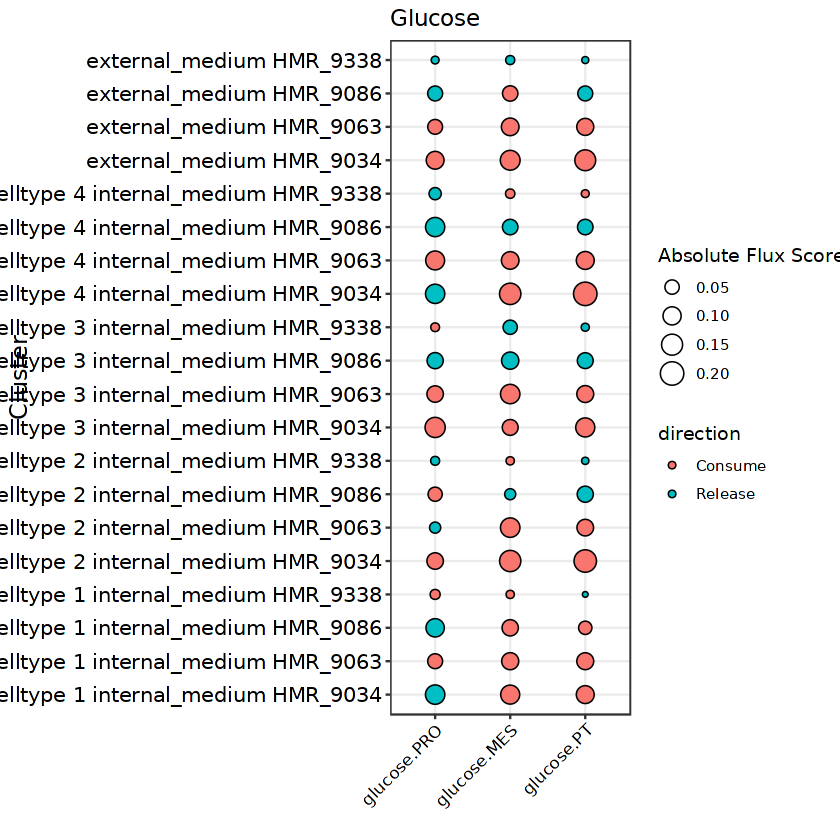

In [31]:
dot_plot

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


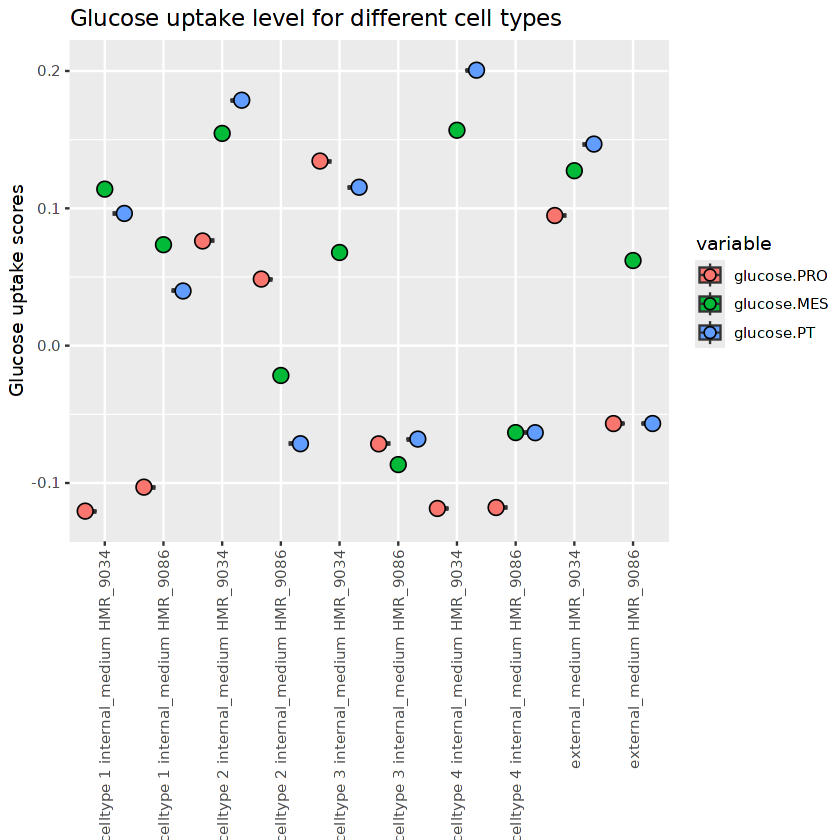

In [23]:
ggplot(long_glucose,aes(y=-value,x=celltype,fill=variable))+
geom_boxplot()+
ggtitle("Glucose uptake level for different cell types")+
xlab("")+ylab("Glucose uptake scores")+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
geom_dotplot(binaxis='y', stackdir='center',
                 position=position_dodge(1))

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


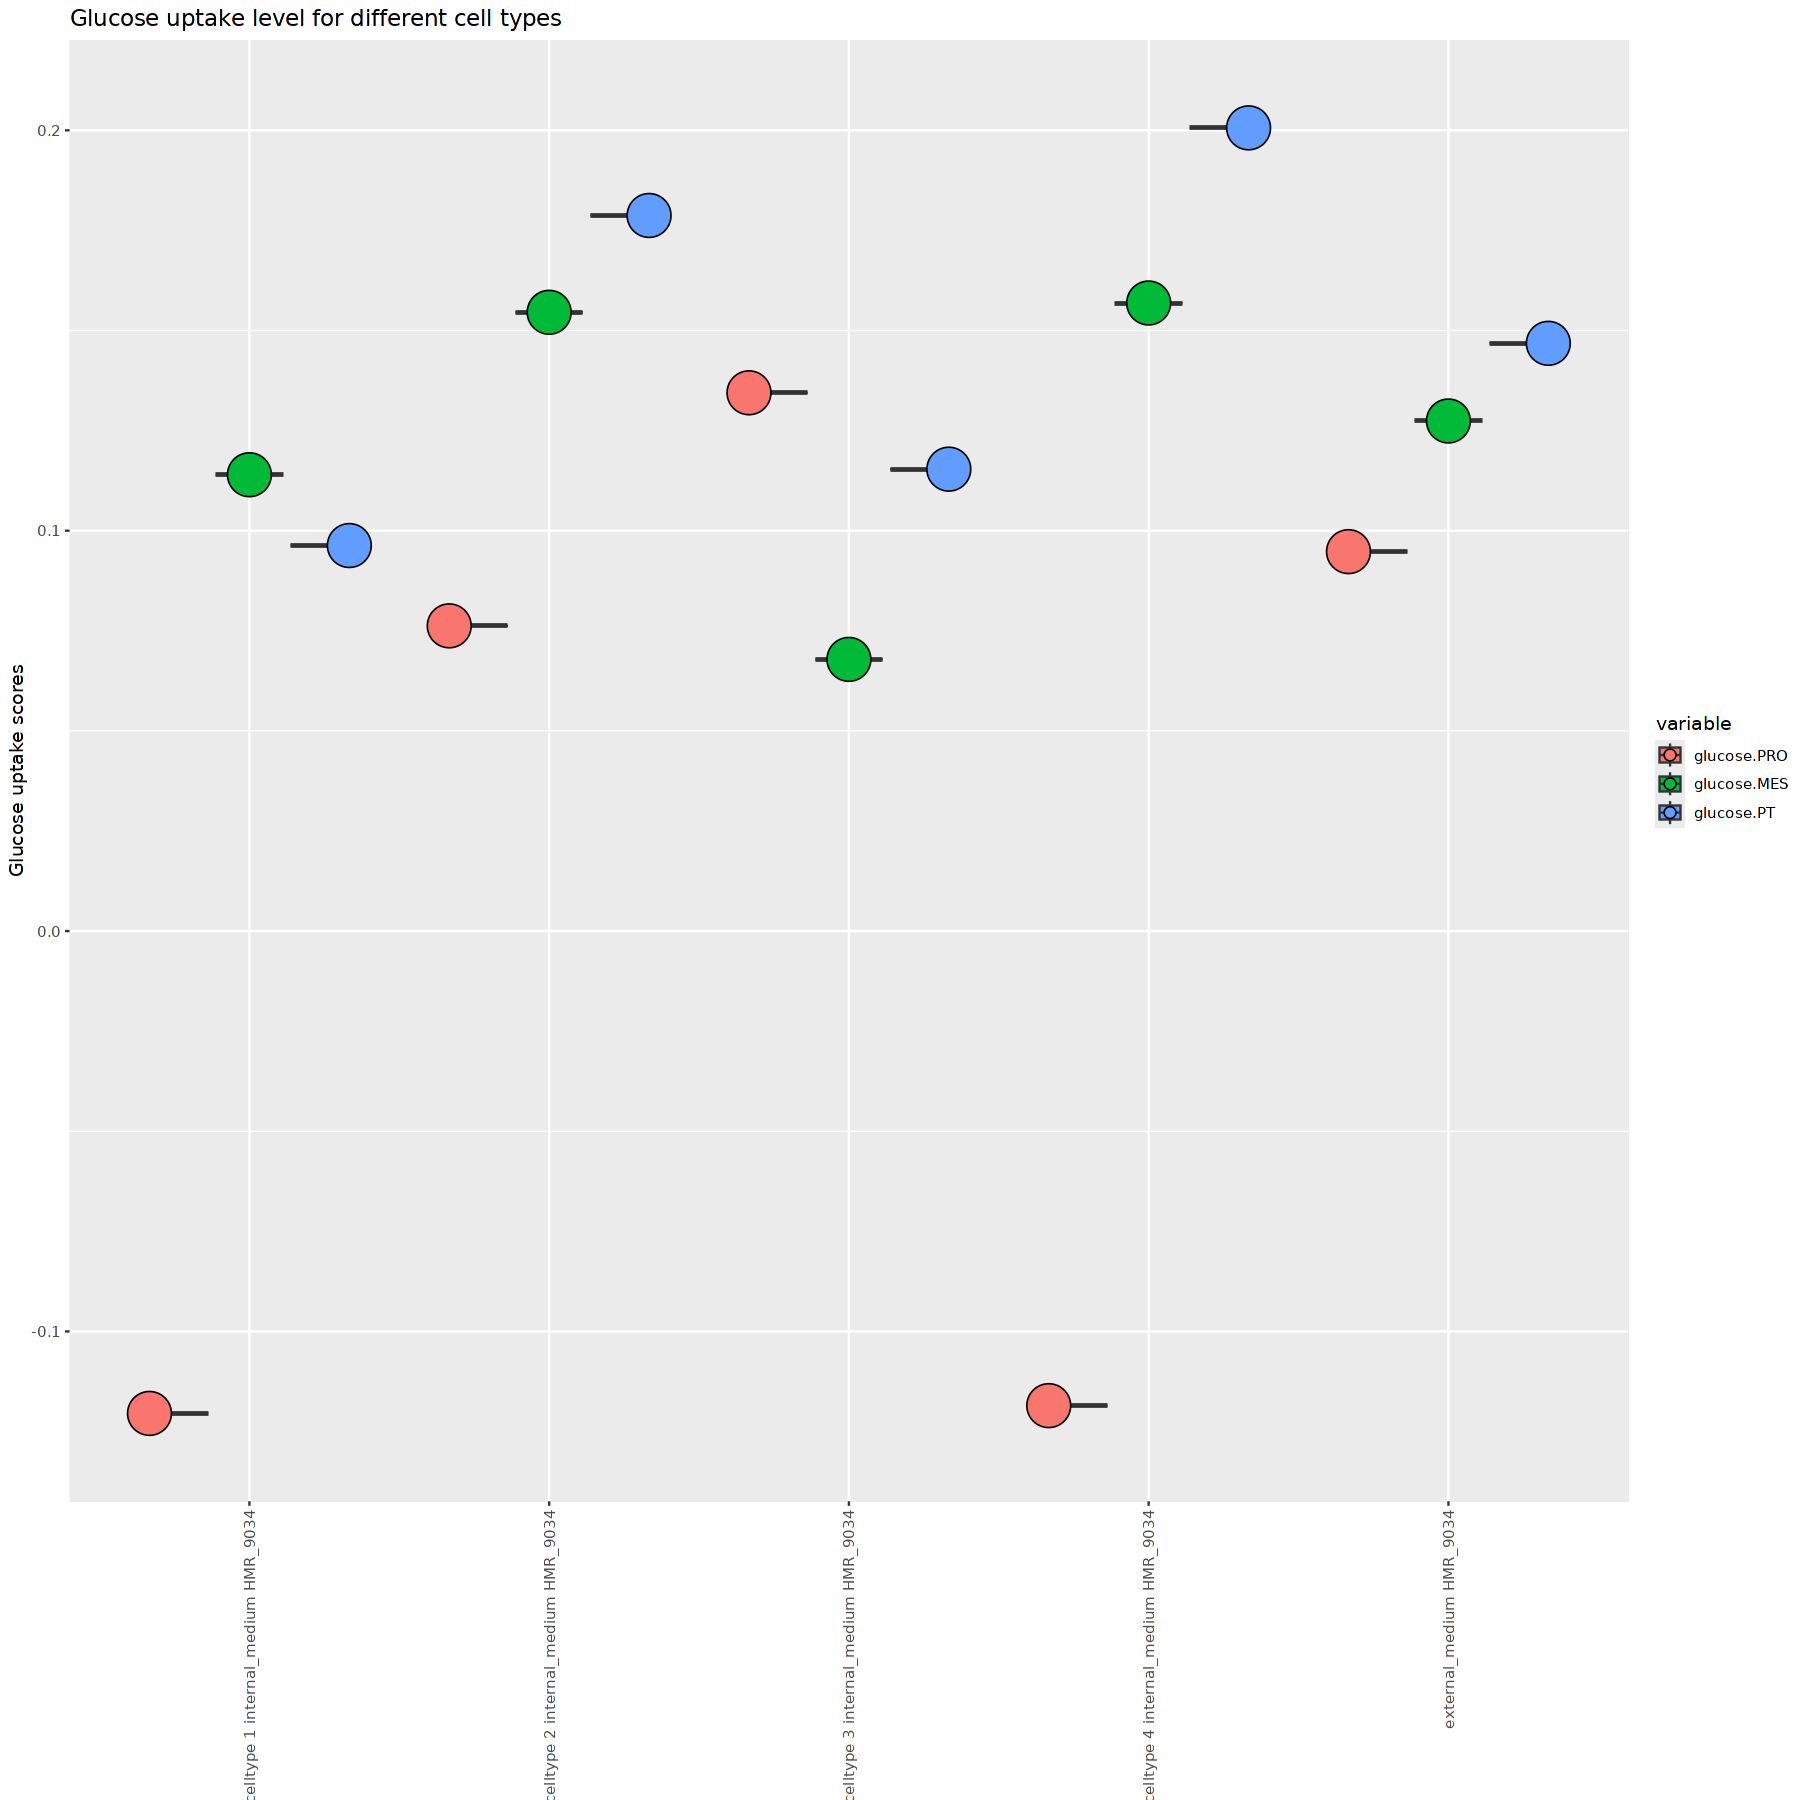

In [144]:
glucose$celltype=rownames(glucose)
long_glucose=reshape2::melt(glucose,id.vars='celltype')
ggplot(long_glucose,aes(y=-value,x=celltype,fill=variable))+
geom_boxplot()+
ggtitle("Glucose uptake level for different cell types")+
xlab("")+ylab("Glucose uptake scores")+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
geom_dotplot(binaxis='y', stackdir='center',
                 position=position_dodge(1))

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“Note: not all columns in the data frame are numeric. The data frame
will be converted into a character matrix.”


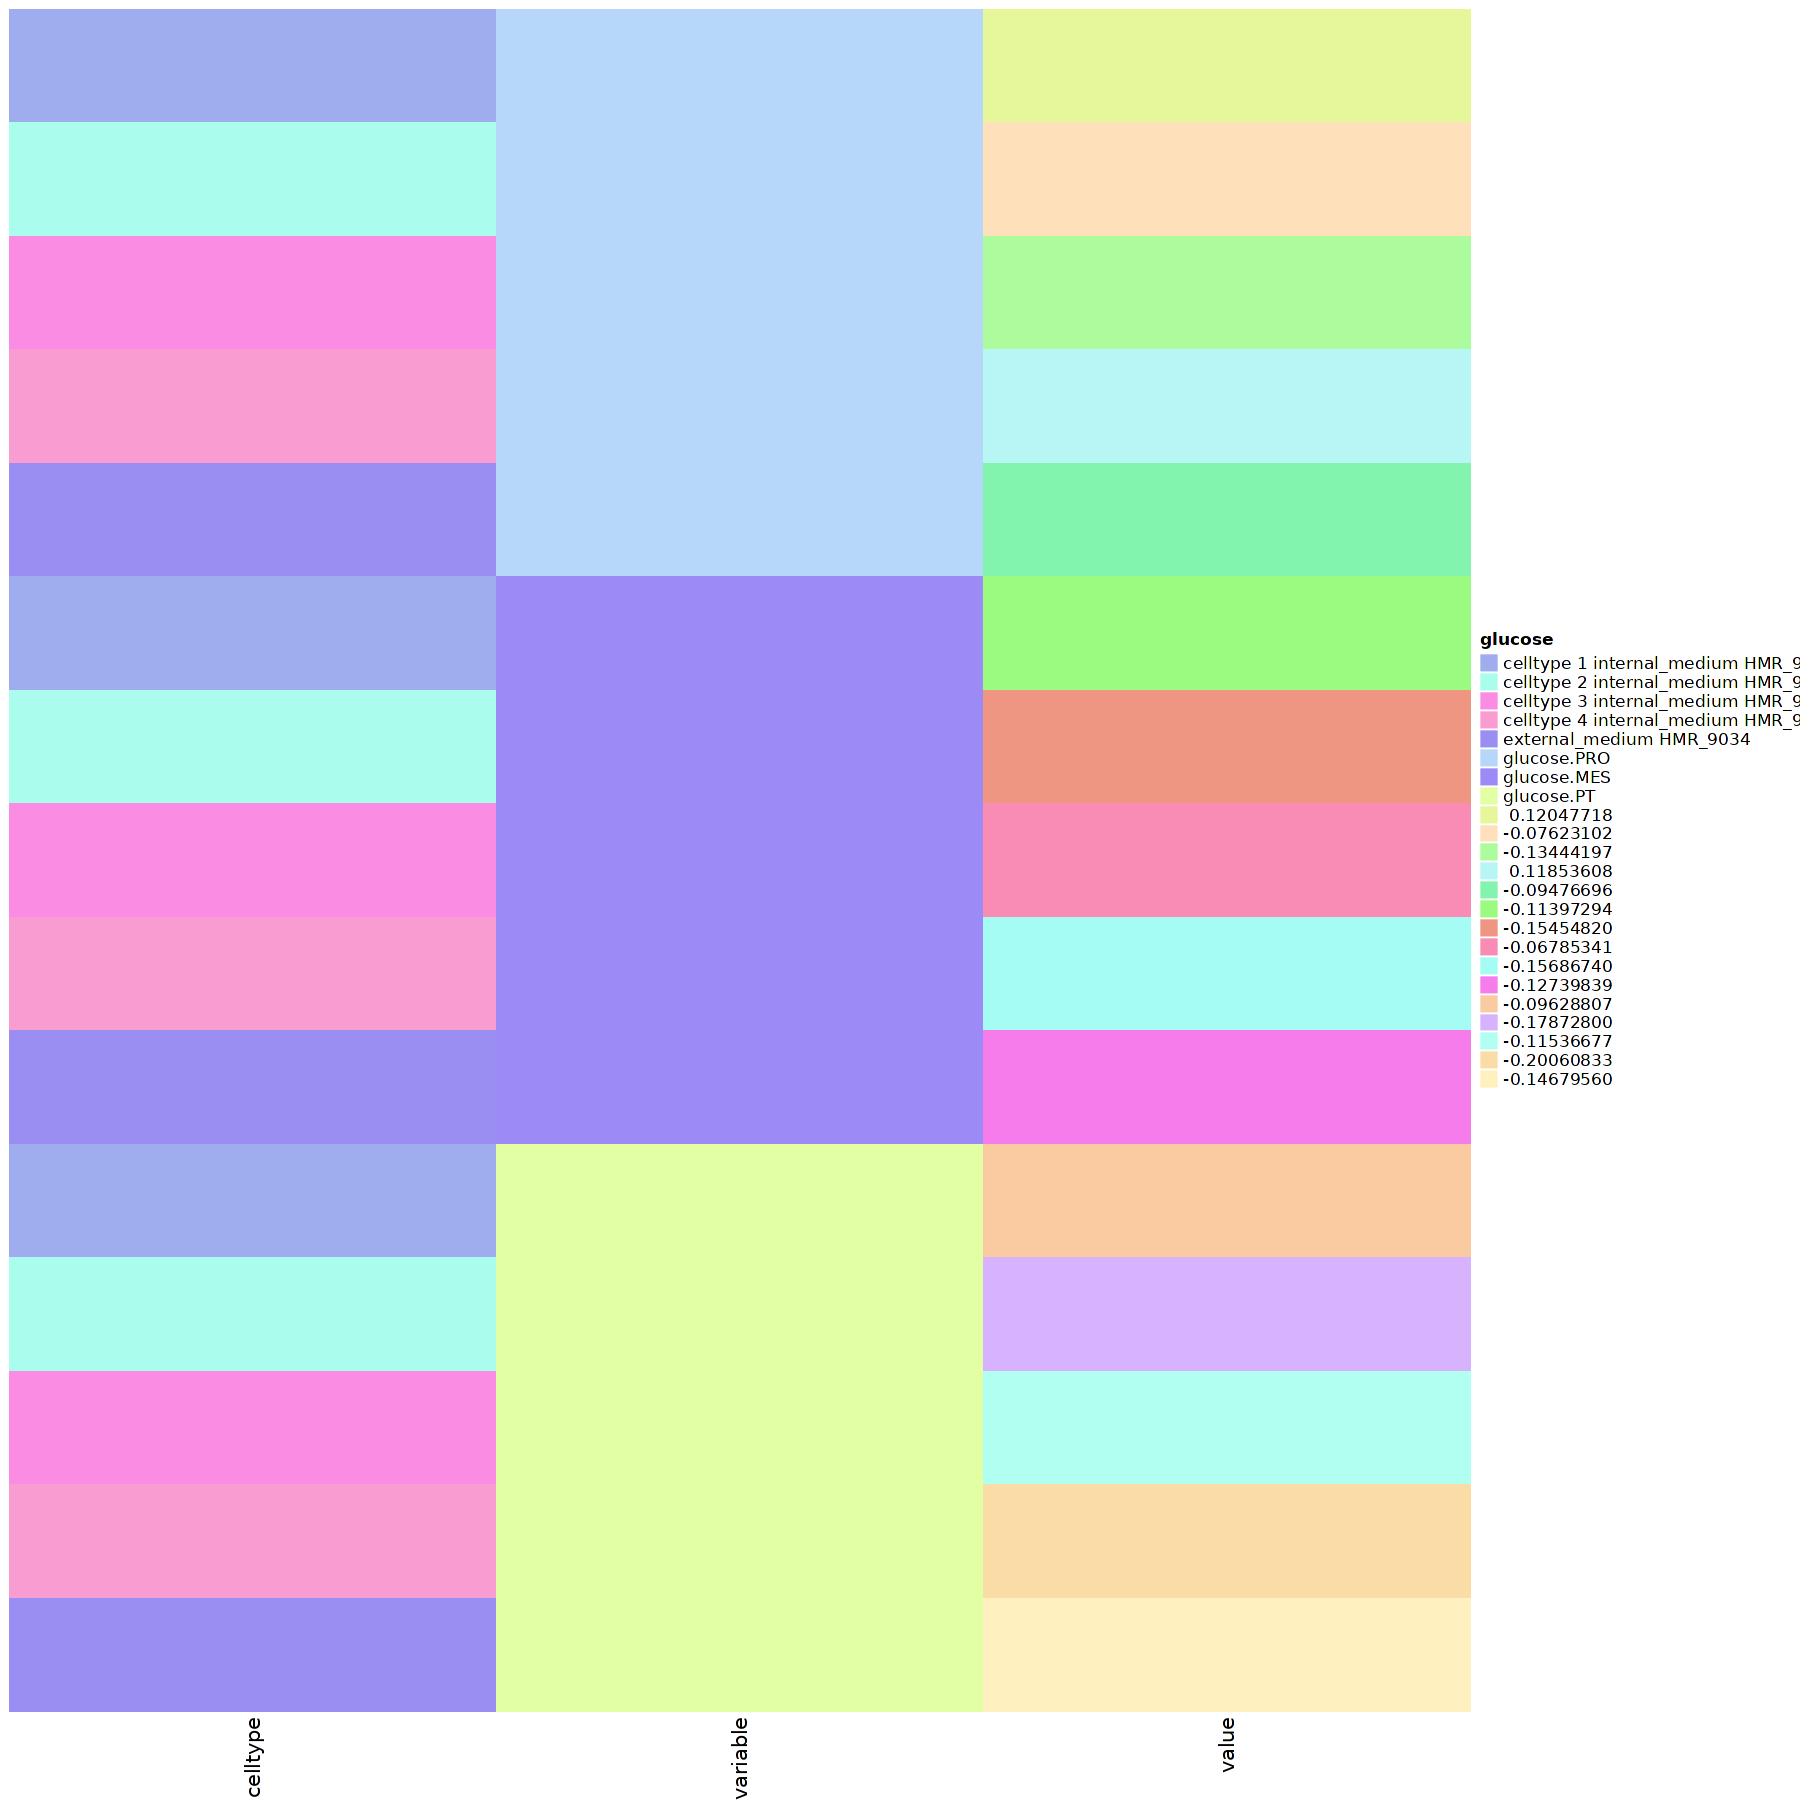

In [136]:
library(ComplexHeatmap)
draw(ComplexHeatmap::Heatmap(long_glucose, name="glucose",
                       row_names_gp=grid::gpar(fontsize=6))) # row font size

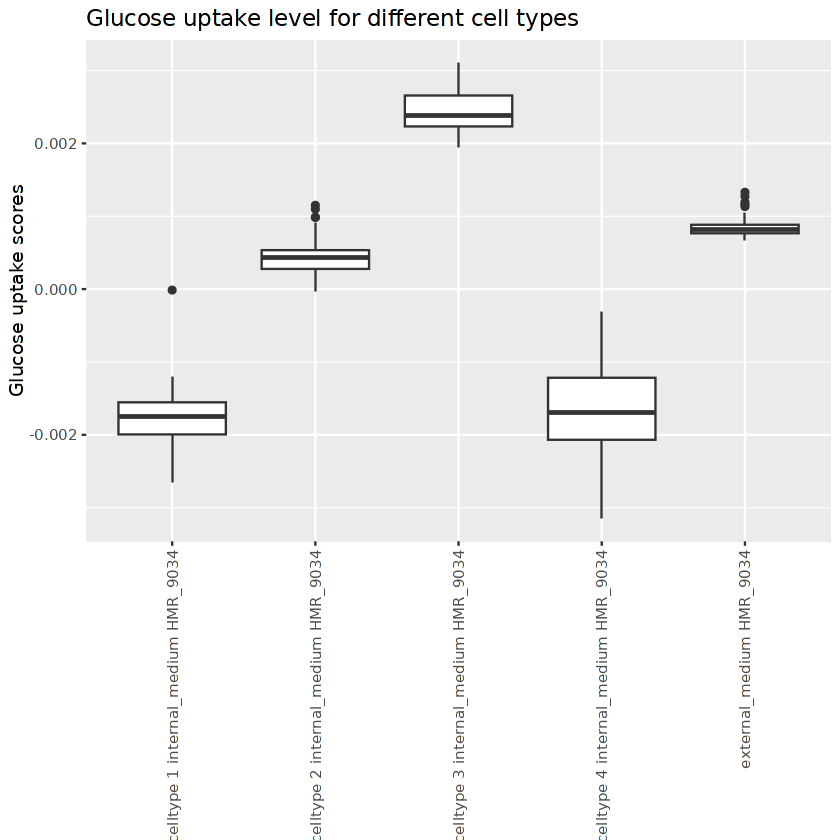

In [23]:
glucose<-data.frame(glucose=pro.flux[grep("HMR_9034",rownames(pro.flux)),])

glucose$celltype=rownames(glucose)
long_glucose=reshape2::melt(glucose,id.vars='celltype')
ggplot(long_glucose,aes(y=-value,x=celltype))+geom_boxplot()+ggtitle("Glucose uptake level for different cell types")+xlab("")+ylab("Glucose uptake scores")+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

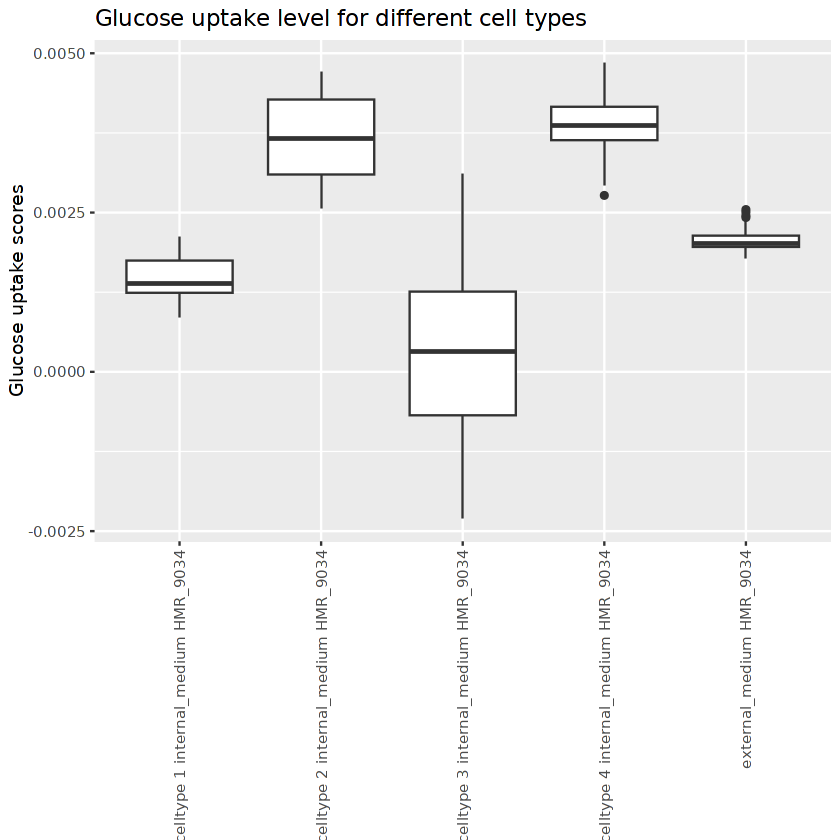

In [25]:
glucose<-data.frame(glucose=mes.flux[grep("HMR_9034",rownames(mes.flux)),])

glucose$celltype=rownames(glucose)
long_glucose=reshape2::melt(glucose,id.vars='celltype')
ggplot(long_glucose,aes(y=-value,x=celltype))+geom_boxplot()+ggtitle("Glucose uptake level for different cell types")+xlab("")+ylab("Glucose uptake scores")+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

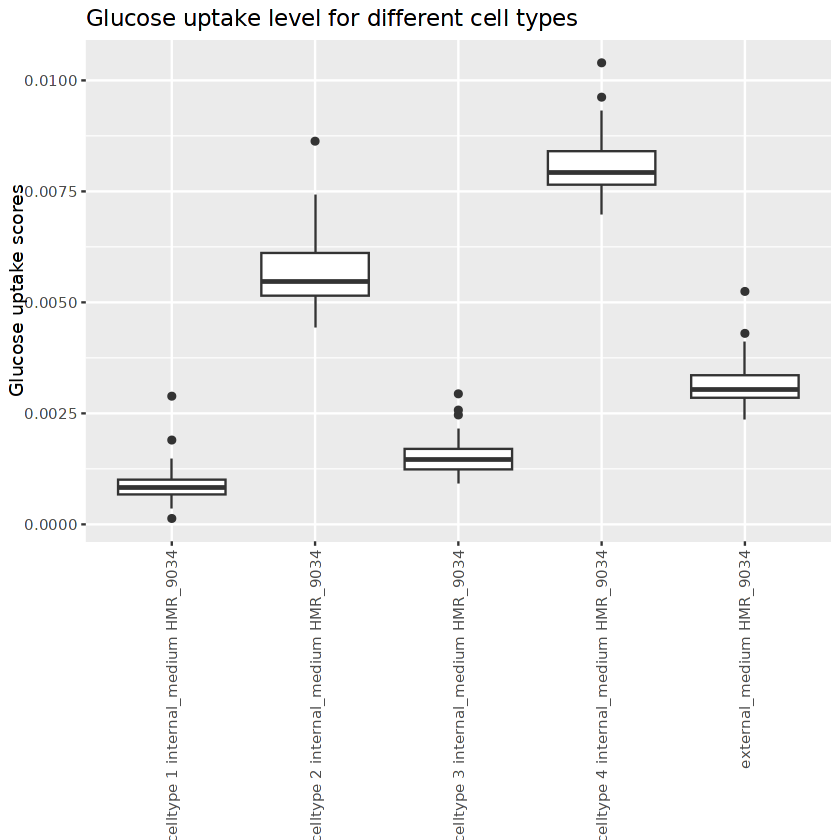

In [35]:
glucose<-data.frame(glucose=pt.flux[grep("HMR_9034",rownames(pt.flux)),])

glucose$celltype=rownames(glucose)
long_glucose=reshape2::melt(glucose,id.vars='celltype')
ggplot(long_glucose,aes(y=-value,x=celltype))+geom_boxplot()+ggtitle("Glucose uptake level for different cell types")+xlab("")+ylab("Glucose uptake scores")+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [99]:
#compute pathway level activity for all samples
pathway<-unique(unlist(human_gem$SUBSYSTEM))
pathway_score<-list()

for (i in pathway){
path=i
activity_score<-c()
for (d in 1:ncol(pro.flux)){
activity_score[d]<-mean(abs(pro.flux[which(unlist(human_gem$SUBSYSTEM)==i),d]))
} 
pathway_score[[i]]<-activity_score
}

all_pathway_score<-as.data.frame(do.call(rbind,pathway_score))
all_pathway_score$PRO <- rowMeans(all_pathway_score[-1])

In [100]:
avg_pathway_scores<- all_pathway_score %>% select(PRO)

In [101]:
#compute pathway level activity for all samples
pathway<-unique(unlist(human_gem$SUBSYSTEM))
pathway_score<-list()

for (i in pathway){
path=i
activity_score<-c()
for (d in 1:ncol(mes.flux)){
activity_score[d]<-mean(abs(mes.flux[which(unlist(human_gem$SUBSYSTEM)==i),d]))
} 
pathway_score[[i]]<-activity_score
}

all_pathway_score<-as.data.frame(do.call(rbind,pathway_score))
all_pathway_score$MES <- rowMeans(all_pathway_score[-1])

In [102]:
avg_pathway_scores$MES <- all_pathway_score$MES 

In [103]:
#compute pathway level activity for all samples
pathway<-unique(unlist(human_gem$SUBSYSTEM))
pathway_score<-list()

for (i in pathway){
path=i
activity_score<-c()
for (d in 1:ncol(pt.flux)){
activity_score[d]<-mean(abs(pt.flux[which(unlist(human_gem$SUBSYSTEM)==i),d]))
} 
pathway_score[[i]]<-activity_score
}

all_pathway_score<-as.data.frame(do.call(rbind,pathway_score))
all_pathway_score$PT <- rowMeans(all_pathway_score[-1])

In [104]:
avg_pathway_scores$PT <- all_pathway_score$PT

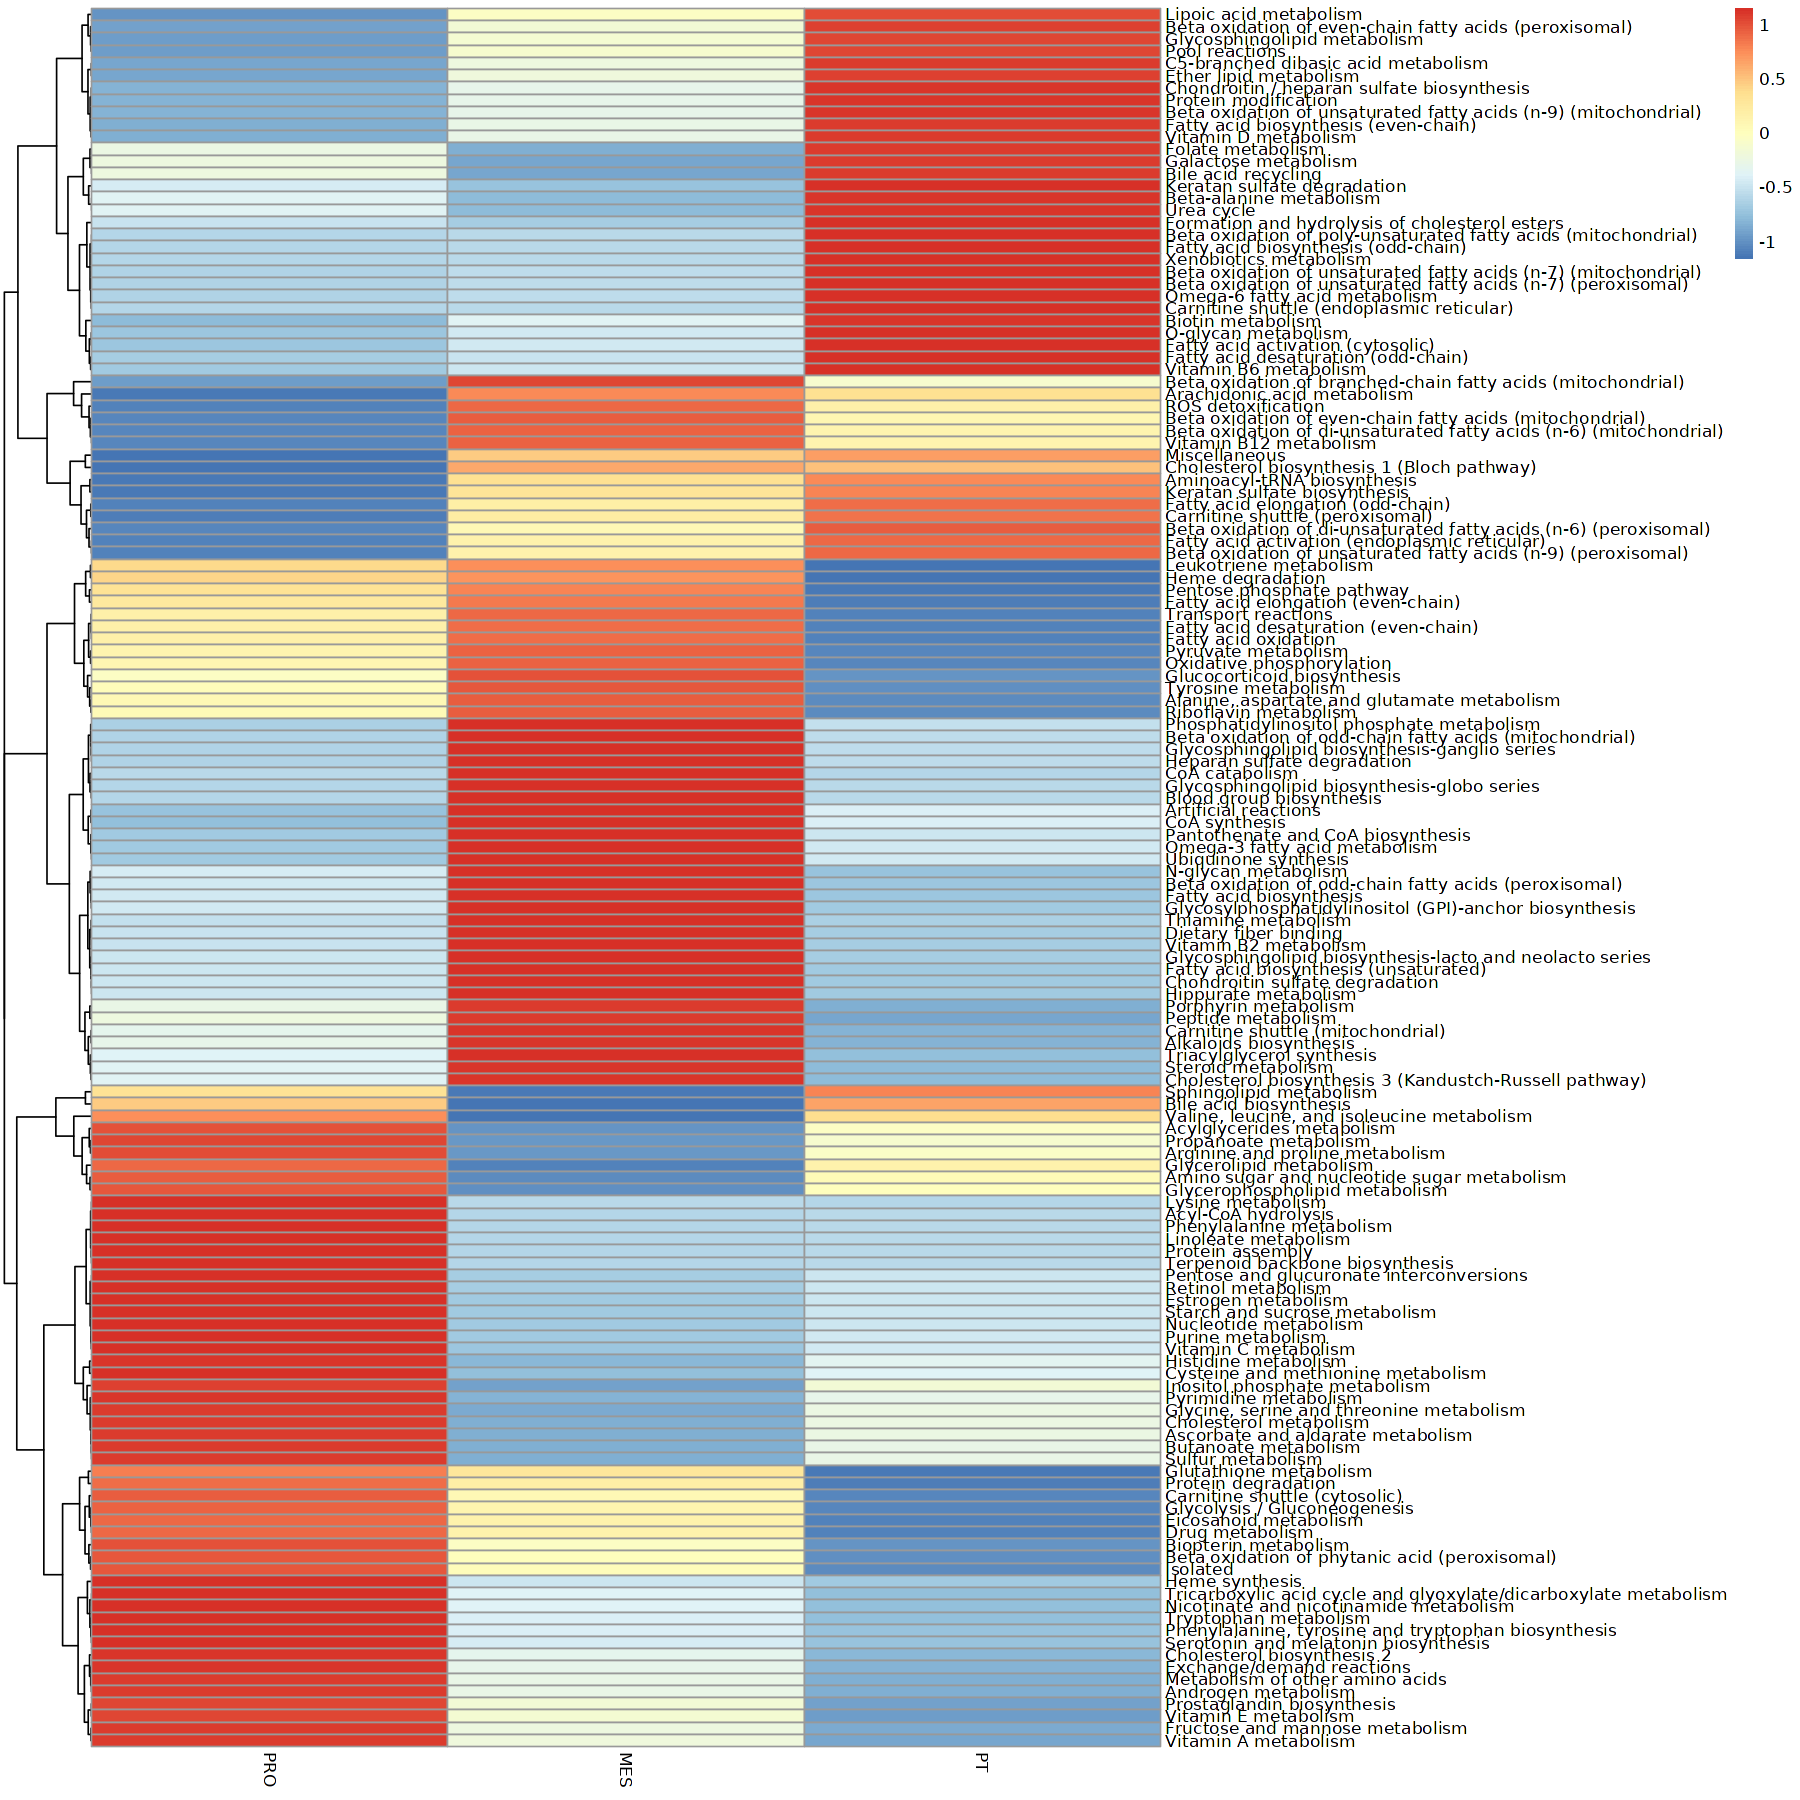

In [115]:
#heatmap 
options(repr.plot.width=15, repr.plot.height=15)


pheatmap::pheatmap(avg_pathway_scores,cluster_cols = F,scale = "row")